# Payment classification pipeline
Before running this notebook make sure to set your project secrets with AWS credentials.

In [ ]:
%pip install --upgrade mlrun --quiet # upgrade mlrun to the latest vesion
%pip install --upgrade sagemaker --quiet # upgrade SageMaker to the latest vesion
%pip install "kfp==1.8.22" "kfp-server-api==1.8.5" --quiet
%pip install "protobuf<4,>=3.20.0" --force-reinstall --quiet

In [4]:
import mlrun

In [5]:
project = mlrun.get_or_create_project(
    name="sagemaker", 
    user_project=True,
    parameters={
        "source" : "git://github.com/mlrun/demo-sagemaker#main",
    },
)

Project Source: git://github.com/mlrun/demo-sagemaker#main
> 2025-06-08 11:54:44,198 [info] Project loaded successfully: {"project_name":"sagemaker-dani"}


### 1. Run the pipeline remotely <a class="anchor" id="Setup"></a>

> 2025-06-08 11:54:44,445 [warning] WARNING!, You seem to have uncommitted git changes, use .push()
> 2025-06-08 11:54:44,963 [info] Pipeline submitted successfully: {"id":"78a8b4e9-8472-4237-a4b3-8b295fdb06c4","pipeline_name":"sagemaker-dani-sagemaker 2025-06-08 11-54-44"}
> 2025-06-08 11:54:44,964 [info] Pipeline run id=78a8b4e9-8472-4237-a4b3-8b295fdb06c4, check UI for progress


> 2025-06-08 11:54:45,043 [info] Started run workflow sagemaker-dani-sagemaker with run id = '78a8b4e9-8472-4237-a4b3-8b295fdb06c4' by kfp engine
> 2025-06-08 11:54:45,044 [info] Waiting for pipeline run completion: {"project":"sagemaker-dani","run_id":"78a8b4e9-8472-4237-a4b3-8b295fdb06c4"}


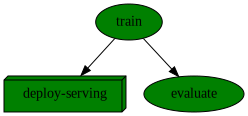

uid,start,end,state,kind,name,parameters,results
...dd3f71a0,Jun 08 12:00:06,2025-06-08 12:00:08.945492+00:00,completed,run,evaluate,model_path=store://artifacts/sagemaker-dani/train_model_path:latest@78a8b4e9-8472-4237-a4b3-8b295fdb06c4^da13f9bcd0f3f948a79f1fd4dfc75c556e0db922model_name=xgboost-modellabel_column=transaction_category,
...d8499f45,Jun 08 11:55:00,2025-06-08 11:59:35.131473+00:00,completed,run,train,,


78a8b4e9-8472-4237-a4b3-8b295fdb06c4

In [6]:
project.run(
    name="sagemaker",
    watch=True,

)

### 2. Infer the deployed model

In [7]:
# get the serving function:
serving_function = project.get_function("serving", sync=True)

In [8]:
sample = [
    4630518417004166.0,
    4898290331783278.0,
    67.18,
    2021.0,
    1.0,
    10.0,
    23.0,
    57.0,
    10.0,
    428.65735483870964,
    15.970618109151054,
    33.79710992816166,
    284.6275883256528,
    40.229440860215064,
    137.55919713261648,
    429.58608602150537,
    2846.4932473118283,
    308.04887096774195,
    714.2121989247312,
    138.27715053763438,
    783.9734946236558,
    33.73750272435426,
    35.675963606286196,
    52.41640479636139,
    26.06939321893735,
    16.107552848441422,
    5957.367483870968,
    47.59955807703791,
]

In [9]:
serving_function.invoke(path='/predict', body={"inputs": [sample]})

{'id': 'b36c8d8c-65e0-486c-bd47-e5d7f9ec53c8',
 'model_name': 'xgboost-model',
 'timestamp': '2025-06-08 12:02:10.839740+00:00',
 'predictions': [17],
 'confidences': [0.3079691231250763]}